# **HW1: Regression** 
In *assignment 1*, you need to finish:

1.  Basic Part: Implement the regression model to predict the number of dengue cases


> *   Step 1: Split Data
> *   Step 2: Preprocess Data
> *   Step 3: Implement Regression
> *   Step 4: Make Prediction
> *   Step 5: Train Model and Generate Result

2.  Advanced Part: Implementing a regression model to predict the number of dengue cases in a different way than the basic part

# 1. Basic Part (60%)
In the first part, you need to implement the regression to predict the number of dengue cases

Please save the prediction result in a csv file **hw1_basic.csv**


## Import Packages

> Note: You **cannot** import any other package in the basic part

In [3277]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import random

## Global attributes
Define the global attributes

In [3278]:
input_dataroot = 'hw1_basic_input.csv'  # Input file named as 'hw1_basic_input.csv'
output_dataroot = 'hw1_basic.csv'       # Output file will be named as 'hw1_basic.csv'

input_datalist =  []                    # Initial datalist, saved as numpy array
output_datalist =  []                   # Your prediction, should be 10 * 4 matrix and saved as numpy array
                                        # The format of each row should be ['epiweek', 'CityA', 'CityB', 'CityC']

You can add your own global attributes here


In [3279]:
# Dataset and datacount
full_data = []
training_data = []
validation_data = []
prediction_data = []
training_data_count = 84
test_data_count = 10
validation = True

# Cleaning parameters
upper_percent = 90
lower_percent = 10

# Regression Parameters
autoregression = 1
max_degree = 2

# Regression coefficients
coef = []

# Advanced dataroots and dataset
advanced_dataroot = "hw1_advanced_input1.csv"
advanced_datalist = []

## Load the Input File
First, load the basic input file **hw1_basic_input.csv**

Input data would be stored in *input_datalist*

In [3280]:
# Read input csv to datalist
with open(input_dataroot, newline='') as csvfile:
    input_datalist = np.array(list(csv.reader(csvfile)))
input_datalist = input_datalist[1: ]

## Implement the Regression Model

> Note: It is recommended to use the functions we defined, you can also define your own functions


### Step 1: Split Data
Split data in *input_datalist* into training dataset and validation dataset 



In [3281]:
def SplitData():
    global training_data, validation_data, prediction_data, full_data
    global training_data_count, validation
    
    # Reset datalists
    training_data = []
    validation_data = []
    prediction_data = []
    full_data = []
    
    # Assign full data
    for data in input_datalist:
        entry = [int(data[0])]
        for cell in data[1: ]:
            if cell == "":
                cell = 0
            entry.append(float(cell))
        full_data.append(entry)
    
    # Assign training data
    if not validation:
        training_data_count += test_data_count
    for data in input_datalist[0: training_data_count]:
        entry = [int(data[0])]
        for cell in data[1: ]:
            if cell == "":
                cell = 0
            entry.append(float(cell))
        training_data.append(entry)

    # Assign validation data
    if validation:
        for data in input_datalist[training_data_count: training_data_count + test_data_count]:
            entry = [int(data[0])]
            for cell in data[1: ]:
                if cell == "":
                    cell = 0
                entry.append(float(cell))
            validation_data.append(entry)
    
    # Assign prediction data
    if not validation:
        training_data_count -= test_data_count
    for data in input_datalist[training_data_count + test_data_count: training_data_count + 2 * test_data_count]:
        entry = [int(data[0])]
        for cell in data[1: ]:
            if cell == "":
                cell = 0
            entry.append(float(cell))
        prediction_data.append(entry)

    # Transpose data
    full_data = np.transpose(np.asarray(full_data, dtype = object))
    training_data = np.transpose(np.asarray(training_data, dtype = object))
    validation_data = np.transpose(np.asarray(validation_data, dtype = object))
    prediction_data = np.transpose(np.asarray(prediction_data, dtype = object))

### Step 2: Preprocess Data
Handle the unreasonable data
> Hint: Outlier and missing data can be handled by removing the data or adding the values with the help of statistics  

In [3282]:
from numpy import percentile


def PreprocessData():
    global training_data

    # Clean data with IQR substitution
    for i in range(1, len(training_data)):
        # percentile_lower = np.percentile(training_data[i], lower_percent)
        # percentile_upper = np.percentile(training_data[i], upper_percent)
        Q1 = np.percentile(training_data[i], 25)
        Q3 = np.percentile(training_data[i], 75)
        IQR = Q3 - Q1
        percentile_lower = Q1 - 1.5 * IQR
        percentile_upper = Q3 + 1.5 * IQR
        for j in range(0, len(training_data[i])):
            if training_data[i][j] < percentile_lower:
                training_data[i][j] = percentile_lower
            elif training_data[i][j] > percentile_upper:
                training_data[i][j] = percentile_upper

### Step 3: Implement Regression
> Hint: You can use Matrix Inversion, or Gradient Descent to finish this part




In [3283]:
def Regression(temp, case):
    global autoregression, max_degree

    M = []
    # Matrix Inversion
    if autoregression != 0:
        for i in range(autoregression, len(temp)):
            phi = [1, temp[i]]
            for j in range(1, autoregression + 1):
                phi.append(case[i - j])             # phi = 1 + temp[i] + case[i - 1] + ...
            M.append(phi)
        coef = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(M), M)), np.transpose(M)), case[autoregression: ])
    else:
        for cell in temp:
            phi = []
            for i in range(0, max_degree + 1):
                phi.append(cell ** i)               # phi = 1 + temp[i] + temp^2[i] + ...
            M.append(phi)
        # w = (phi^T * phi)^-1 * y
        coef = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(M), M)), np.transpose(M)), case)
    return coef

### Step 4: Make Prediction
Make prediction of testing dataset and store the value in *output_datalist*

In [3284]:
def MakePrediction(coef, temp, case):
    global autoregression, max_degree

    result = []
    for i in range(autoregression, len(temp)):
        if autoregression != 0:
            predict = coef[0] + coef[1] * temp[i]
            for j in range(1, autoregression + 1):
                if i - autoregression <= 0:
                    predict += coef[j + 1] * case[i - j]
                else:
                    predict += coef[j + 1] * result[i - autoregression - 1]
        else:
            predict = 0
            for j in range(0, max_degree + 1):
                predict += coef[j] * (temp[i] ** j)
        result.append(int(predict))
    return result

### Step 4.5: Utility Functions
Utility functions for visualizations and monitoring errors

In [3285]:
def MAPE(coef, id):
    global autoregression
    global training_data, validation_data

    temp = []
    case = []
    if autoregression != 0:
        for i in range(1, autoregression + 1):
            temp.append(training_data[id][len(training_data[id]) - i])
        for entry in validation_data[id]:
            temp.append(entry)
        for i in range(1, autoregression + 1):
            case.append(training_data[id + 3][len(training_data[id + 3]) - i])
        for entry in validation_data[id + 3]:
            case.append(entry)
    else:
        temp = validation_data[id]
        case = validation_data[id + 3]
    predict = MakePrediction(coef, temp, case)
    plt.scatter(temp[autoregression: ], predict, c = 'r')
    error = 0

    for i in range(0, len(predict)):
        if case[i] == 0:
            print(i, temp[i], case[i])
        error = error + abs((case[i] - predict[i]) / case[i])
    return error / len(case) * 100

def Visualization(coef, id):
    global autoregression
    global training_data, validation_data

    MeanAbsolutePercentageError = round(MAPE(coef, id), 2)
    # MAPE
    print("MAPE: {0}%".format(MeanAbsolutePercentageError, 2))
    
    # Scatter plot
    plt.scatter(training_data[id], training_data[id + 3])
    plt.scatter(validation_data[id], validation_data[id + 3])

    # Polynomial curve
    if autoregression == 0:
        x = np.linspace(20, 30)
        all_predictor = np.poly1d(coef[::-1])
        y = all_predictor(x)
        plt.plot(x, y, c = 'r')
    
    plt.show()
    return MeanAbsolutePercentageError

### Step 5: Train Model and Generate Result

> Notice: **Remember to output the coefficients of the model here**, otherwise 5 points would be deducted
* If your regression model is *3x^2 + 2x^1 + 1*, your output would be: 
```
3 2 1
```





MAPE: 31.62%


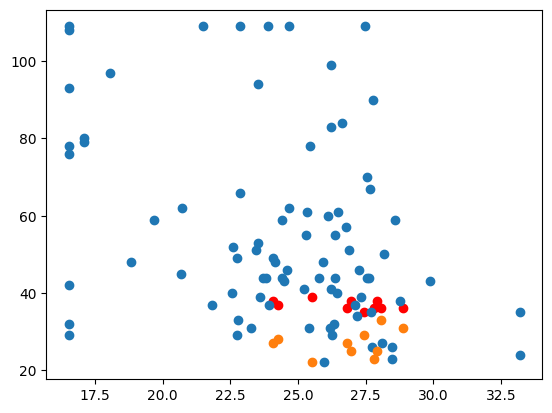

MAPE: 19.88%


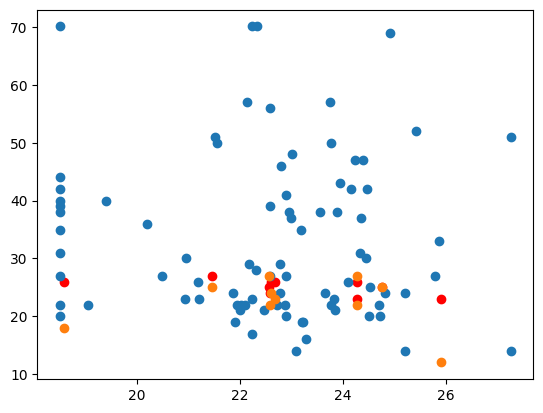

MAPE: 9.62%


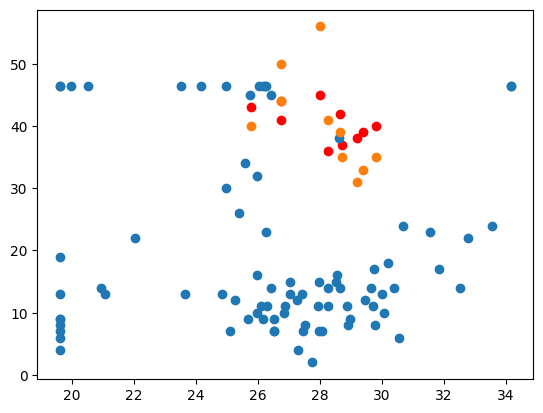

Total MAPE: 20.37333333333333%


In [3286]:
# Split Data
SplitData()

# Preprocess Data
PreprocessData()

# Regression
for i in range(1, 4):
    coef.append(Regression(training_data[i], training_data[i + 3]))

# Coefficient Output


# Visualization
if validation:
    total_MAPE = 0
    for i in range(0, 3):
        total_MAPE += Visualization(coef[i], i + 1)
    print("Total MAPE: {0}%".format(total_MAPE / 3))

# Prediction data
output_datalist.append(prediction_data[0])
for i in range(1, 4):
    x = []
    y = []
    if autoregression != 0:
        for j in range(1, autoregression + 1):
            x.append(full_data[i][len(full_data[i]) - test_data_count - j])
        for entry in prediction_data[i]:
            x.append(entry)
        for j in range(1, autoregression + 1):
            y.append(full_data[i][len(full_data[i + 3]) - test_data_count - j])
        for entry in prediction_data[i + 3]:
            y.append(entry)
    else:
        x = prediction_data[i]
        y = prediction_data[i + 3]
    output_datalist.append(MakePrediction(coef[i - 1], x, y))
output_datalist = np.transpose(np.asarray(output_datalist, dtype = object))

## Write the Output File
Write the prediction to output csv
> Format: 'epiweek', 'CityA', 'CityB', 'CityC'

In [3287]:
with open(output_dataroot, 'w', newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for row in output_datalist:
        writer.writerow(row)

# 2. Advanced Part (35%)
In the second part, you need to implement the regression in a different way than the basic part to help your predictions for the number of dengue cases

We provide you with two files **hw1_advanced_input1.csv** and **hw1_advanced_input2.csv** that can help you in this part

Please save the prediction result in a csv file **hw1_advanced.csv** 


## Step 1: Read and Split Data

In [3288]:
# Read input csv to datalist
with open(advanced_dataroot, newline='') as csvfile:
    advanced_datalist = np.array(list(csv.reader(csvfile)))
advanced_datalist = np.transpose(advanced_datalist[1: ])

def SplitDataAdvanced():
    global training_data_count, validation
    global training_data, validation_data, prediction_data, advanced_datalist, full_data
    
    for data in advanced_datalist[1: ]:
        training_data = list(training_data)
        prediction_data = list(prediction_data)
        full_data = list(full_data)
        full_data.append(np.asarray(data, dtype = float))
        if validation:
            training_data.append(np.asarray(data[0: training_data_count], dtype = float))
            validation_data = list(validation_data)
            validation_data.append(np.asarray(data[training_data_count: training_data_count + test_data_count], dtype = float))
            prediction_data.append(np.asarray(data[training_data_count + test_data_count: training_data_count + test_data_count * 2], dtype = float))
        else:
            training_data.append(np.asarray(data[0: training_data_count + test_data_count], dtype = float))
            prediction_data.append(np.asarray(data[training_data_count + test_data_count: training_data_count + test_data_count * 2], dtype = float))
        training_data = np.asarray(training_data, dtype = object)
        prediction_data = np.asarray(prediction_data, dtype = object)
        validation_data = np.asarray(validation_data, dtype = object)

### Step 2: Preprocess New Data

In [3289]:
def PreprocessDataAdvanced():
    global training_data
    for i in range(7, len(training_data)):
        Q1 = np.percentile(training_data[i], 25)
        Q3 = np.percentile(training_data[i], 75)
        IQR = Q3 - Q1
        percentile_lower = Q1 - 1.5 * IQR
        percentile_upper = Q3 + 1.5 * IQR
        for j in range(0, len(training_data[i])):
            if training_data[i][j] < percentile_lower:
                training_data[i][j] = percentile_lower
            elif training_data[i][j] > percentile_upper:
                training_data[i][j] = percentile_upper

## Step 3: Advanced Regression

In [3290]:
def RegressionAdvanced(temp, case, prec):
    global autoregression, max_degree

    M = []
    # Matrix Inversion
    if autoregression != 0:
        for i in range(autoregression, len(temp)):
            phi = [1, temp[i], prec[i]]
            for j in range(1, autoregression + 1):
                phi.append(case[i - j])             # phi = 1 + temp[i] + case[i - 1] + ...
            M.append(phi)
        coef = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(M), M)), np.transpose(M)), case[autoregression: ])
    else:
        for i in range(0, len(temp)):
            phi = [1]
            for j in range(1, max_degree + 1):
                phi.append(temp[i] ** j)               
                phi.append(prec[i] ** j)             # phi = 1 + temp[i] + prec[i] + temp^2[i] + prec^2[i]...
            M.append(phi)
        # w = (phi^T * phi)^-1 * y
        coef = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(M), M)), np.transpose(M)), case)
    return coef

## Step 4: Make Prediction

In [3291]:
def MakePredictionAdvanced(coef, temp, case, prec):
    global autoregression, max_degree

    result = []
    for i in range(autoregression, len(temp)):
        if autoregression != 0:
            predict = coef[0] + coef[1] * temp[i] + coef[2] * prec[i]
            for j in range(1, autoregression + 1):
                if i - autoregression <= 0:
                    predict += coef[j + 2] * case[i - j]
                else:
                    predict += coef[j + 2] * result[i - autoregression - 1]
        else:
            predict = coef[0]
            for j in range(1, max_degree + 1):
                predict += coef[2 * j - 1] * (temp[i] ** j)
                predict += coef[2 * j] * (prec[i] ** j)
        result.append(int(predict))
    return result

## Step 4.5: More Utility Functions


In [3292]:
def MAPEAdvanced(coef, id):
    global autoregression
    global training_data, validation_data

    temp = []
    case = []
    prec = []
    if autoregression != 0:
        for i in range(1, autoregression + 1):
            temp.append(training_data[id][len(training_data[id]) - i])
        for entry in validation_data[id]:
            temp.append(entry)
        for i in range(1, autoregression + 1):
            case.append(training_data[id + 3][len(training_data[id + 3]) - i])
        for entry in validation_data[id + 3]:
            case.append(entry)
        for i in range(1, autoregression + 1):
            prec.append(training_data[id + 6][len(training_data[id + 6]) - i])
        for entry in validation_data[id + 6]:
            prec.append(entry)
    else:
        temp = validation_data[id]
        case = validation_data[id + 3]
        prec = validation_data[id + 6]
    predict = MakePredictionAdvanced(coef, temp, case, prec)
    error = 0

    for i in range(0, len(predict)):
        if case[i] == 0:
            print(i, temp[i], case[i])
        error = error + abs((case[i] - predict[i]) / case[i])
    return error / len(case) * 100

## Step 5: Train and Predict

In [3293]:
# Parameters
autoregression = 0
max_degree = 4

# Split Data
SplitDataAdvanced()

# Preprocess Data
PreprocessDataAdvanced()

# Regression
coef = []
for i in range(1, 4):
    coef.append(RegressionAdvanced(training_data[i], training_data[i + 3], training_data[i + 6]))

# Visualization
if validation:
    print("MAPE A: {0}%".format(MAPEA := round(MAPEAdvanced(coef[0], 1), 2)))
    print("MAPE B: {0}%".format(MAPEB := round(MAPEAdvanced(coef[0], 2), 2)))
    print("MAPE C: {0}%".format(MAPEC := round(MAPEAdvanced(coef[0], 3), 2)))
    print("Total MAPE: {0}%".format(round((MAPEA + MAPEB + MAPEC) / 3, 2)))

# Prediction data
output_datalist = list([])
output_datalist.append(list(prediction_data[0]))
for i in range(1, 4):
    x1 = []
    y = []
    x2 = []
    if autoregression != 0:
        for j in range(1, autoregression + 1):
            x1.append(full_data[i][len(full_data[i]) - test_data_count - j])
        for entry in prediction_data[i]:
            x1.append(entry)
        for j in range(1, autoregression + 1):
            y.append(full_data[i][len(full_data[i + 3]) - test_data_count - j])
        for entry in prediction_data[i + 3]:
            y.append(entry)
        for j in range(1, autoregression + 1):
            x2.append(full_data[i][len(full_data[i + 6]) - test_data_count - j])
        for entry in prediction_data[i + 6]:
            x2.append(entry)
    else:
        x1 = prediction_data[i]
        y = prediction_data[i + 3]
        x2 = prediction_data[i + 6]
    output_datalist.append(MakePredictionAdvanced(coef[i - 1], x1, y, x2))
output_datalist = np.asarray(output_datalist, dtype = object)
output_datalist = np.transpose(np.asarray(output_datalist, dtype = object))

MAPE A: 97.22%
MAPE B: 148.68%
MAPE C: 68.74%
Total MAPE: 104.88%


## Step 6: Write

In [3294]:
output_dataroot = "hw1_advanced.csv"
with open(output_dataroot, 'w', newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for row in output_datalist:
        writer.writerow(row)

# Report *(5%)*

Report should be submitted as a pdf file **hw1_report.pdf**

*   Briefly describe the difficulty you encountered 
*   Summarize your work and your reflections 
*   No more than one page






# Save the Code File
Please save your code and submit it as an ipynb file! (**hw1.ipynb**)